<h1 id="Title">Topographic Differencing and Error Analysis Toolkit</h1>
 


<h2 id="Setup">1. Setup</h2>

<h3 id="API-Key">Finding and storing your API Key</h3>


We recommend storing your OT API key in a environment variable. This prevents keys from being hardcoded in the source code, reducing the risk of exposure through sharing or version control. It also enhances flexibility, allowing the same code to be used in various environments without changes. Below are the steps to take to store your API key in an environment variable.  

<h4 id="Linux-macOS">For Linux/macOS</h4>

Open up a Terminal window and find your shell's profile script. For Bash, you might find '~ /.bashrc' or '~ /.bash_profile'.
For Zsh, you might find '~ /.zshrc'.  

```cd ~```  
```ls -a```  

Once you know the name of your shell’s profile script, you can edit it using a text editor that operates in the terminal (like ```nano``` or ```vim```) or out side the terminal with the text editor of your choosing. This example will use '~/.zshrc' as the name of the shell profile script and ```nano``` as the text editor. If the file is read-only, you might need to use ```sudo``` to edit it.  

```nano ~/.zshrc```  

At the end of the .zshrc file, add a line to define your environment variable. 'your_api_key_here' is a stand in for the alphanumeric API key accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."   
 
```export OPENTOPOGRAPHY_API_KEY='your_api_key_here'```


Exit (```control + X``` for ```nano```) and save (```Y``` to ```Save modified buffer (ANSWERING "No" WILL DESTROY CHANGES) ?``` then ```Enter``` for ```nano```).

For your changes to take effect, you need to reload the .zshrc file or restart your terminal. To reload .zshrc without restarting, type the following command in your terminal and press Enter:  

```source ~/.zshrc```  

This will make the OPENTOPOGRAPHY_API_KEY environment variable available in all new terminal sessions.  

<h4 id="Windows">For Windows</h4> 

1. Search for "Environment Variables" in the Start menu.
1. Click on "Edit the system environment variables."
1. In the System Properties window, click on "Environment Variables."
1. Click on "New" under System variables or User variables depending on your need.
1. Set "Variable name" as OPENTOPOGRAPHY_API_KEY and "Variable value" as your actual API key. Your alphanumeric API key is accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."
1. Click OK and apply the changes.

<h3 id="Colab">Running the notebook in Colab</h3>

For ease-of-use, it is suggested to launch and execute these notebooks on <a href="https://colab.research.google.com/">Google Colaboratory</a> (Colab, for short), Google's Cloud Platform. Dependencies will be installed on a virtual machine on Google's cloud servers and the code will be executed directly in your browser! A major benefit of this is that you will have direct access to Google's high-end CPU/GPUs and will not have to install any dependencies locally. All deliverables will be saved to your personal Google Drive. To experiment and run one of the below Jupyter Notebooks on Google Colab click the "Open in Colab" badge below.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Cassandra-Brigham/sage-gage-exercise/blob/main/topographic_processing_notebook.ipynb)


In [1]:
# This cell only excecutes if you're running on Colab. Installation process takes 2-3 minutes.
import os, sys
if 'google.colab' in sys.modules:
    
  # Mount Google Drive. You will be prompted to grant file I/O access to Drive.
  from google.colab import drive 
  drive.mount('/gdrive/') # Mount Google Drive! 

  # Clone OpenTopography 3DEP Workflow Git Repository
  !git clone https://github.com/Cassandra-Brigham/sage-gage-exercise

  #  Install the core dependencies (other than PDAL/GDAL) from requirements.txt
  !pip install -r sage-gage-exercise/requirements.txt

  # Install Conda (necessary to install PDAL/GDAL)
  !pip install -q condacolab
  import condacolab
  condacolab.install()

  #kernel will restart. Install PDAL and GDAL with Mamba.
  !mamba install -q python-pdal gdal
  
  # Runtime will restart automatically. Do not rerun above cells.

In [ ]:
# This cell only excecutes if you're running on Colab.
import os, sys
if 'google.colab' in sys.modules:
    # Colab requires proj_lib environment variable to be set manually.
    os.environ['PROJ_LIB'] = '/usr/local/share/proj/'

    !pip install python-dotenv  # if not already installed

    from dotenv import set_key, find_dotenv

    # 1) Locate (or create) your .env
    #    find_dotenv returns the first .env in cwd hierarchy, or '' if none
    env_path = find_dotenv(usecwd=True)
    if not env_path:
        env_path = ".env"
        open(env_path, "a").close()

    # 2) Define your variables
    variables = {
        "OPENTOPOGRAPHY_API_KEY": os.getenv("OPENTOPOGRAPHY_API_KEY", "default_value"),
    }

    # 3) Write/update each key in the .env
    for key, val in variables.items():
        set_key(env_path, key, val)

    print(f".env updated at {env_path}")

%cd sage-gage-exercise/ 

<h3 id="Libraries">Import required libraries</h3>

In [ ]:
import colormaps as cmaps
import os
import numpy as np

from differencing_functions import DataAccess, OpenTopographyQuery, Raster, RasterPair, GeoidTransformer, GetDEMs, TerrainDerivatives, TopoDifferencer
from variography_uncertainty import RasterDataHandler, StatisticalAnalysis, VariogramAnalysis, UncertaintyCalculation, ApplyUncertainty
from stable_unstable_areas import TopoMapInteractor, StableAreaRasterizer, StableAreaAnalyzer

<h2 id="Data-Access-and-Processing">2. Data access, download and pre-processing</h2>
<h3 id="Load-API-Key">Load API key</h2>

In [2]:
# After setting the environment variable, access your API key in this notebook.
API_Key = os.getenv('OPENTOPO_ADMIN_ENTERPRISE_API_KEY')

# If your API key is not set, you can set it here.
# API_Key = "your_api_key_here"

if API_Key is not None:
    print("API Key loaded successfully!")
else:
    print("Failed to load API Key.")

API Key loaded successfully!


<h3 id="Define-AOI"> Define area of interest</h3>

To specify the geographic region for your dataset search, you have three options. You can 1) manually enter latitude and longitude bounds if you know the exact coordinates of your area of interest; 2) upload a shapefile or GEOJSON to automatically populate the same extent variables; 3) draw a bounding box directly on the interactive map embedded in this notebook: simply click and drag to sketch the rectangle around your target area, and the notebook captures both the corner coordinates and the equivalent WKT polygon for your API queries.

<h4 id="Option-1-Draw-Map"> Option 1: Draw a bounding box on an interactive map</h4>

In [3]:
da = DataAccess()
da.init_ot_catalog_map(zoom=3)

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [4]:
da.bounds

{'south': 47.199977,
 'west': -92.079163,
 'north': 47.222366,
 'east': -92.028351,
 'polygon_wkt': ['-92.079163, 47.199977, -92.079163, 47.222366, -92.028351, 47.222366, -92.028351, 47.199977, -92.079163, 47.199977']}

<h4 id="Option-2-Manual-Bounds"> Option 2: Define bounds manually</h4>

In [ ]:
da = DataAccess()
south = 41.41898
north = 41.419882
west = -84.982467
east = -84.98148
da.define_bounds_manual(south, north, west, east)

<h4 id="Option-3-Upload-File">Option 3: Define bounds using an uploaded file</h4>

In [ ]:
path = "path/to/shapefile.shp"

da = DataAccess()

da.define_bounds_from_file(path, target_crs = 'EPSG:4326')

<h3 id="Use-OT-Catalog"> Use OT Catalog To Find Datasets</h3>

This section uses OpenTopography’s `otCatalog` API endpoint to perform a bounding‐box search of available datasets within the area of interest defined above. 

In [5]:
# Initialize the OpenTopography query object with our DataAccess instance
otq = OpenTopographyQuery(da)

catalog_df = otq.query_catalog(
    product_format="PointCloud",    # only return point cloud products; use "Raster" or omit to get all
    include_federated=True,         # include external catalogs (e.g. USGS 3DEP) via OpenTopography
    detail=False,                   # set to True for full metadata; False returns summary fields
    save_as="results.json"          # save raw JSON response to this file for inspection or reuse
)

# Show the first few rows of the catalog dataframe
catalog_df.head()

Name       ID type Data Source  \
0                  MN LakeSuperior 1 2021  USGS_3DEP_ID        usgs   
1                            MN FullState  USGS_3DEP_ID        usgs   
2  USGS LPC MN Arrowhead B4 2011 LAS 2016  USGS_3DEP_ID        usgs   
3    2012 MN DNR Lidar: Duluth Post-Flood        NOAAID        noaa   

                              Property ID Horizontal EPSG  \
0                  MN_LakeSuperior_1_2021            3857   
1                            MN_FullState            3857   
2  USGS_LPC_MN_Arrowhead_B4_2011_LAS_2016            3857   
3                                    9075            6344   

          Vertical Coordinates                              Clean Name  
0  NAVD88 height - Geoid18 (m)                  MN_LakeSuperior_1_2021  
1                          N/A                            MN_FullState  
2    NAVD88 - Geoid09 (Meters)  USGS_LPC_MN_Arrowhead_B4_2011_LAS_2016  
3                NAVD88 height     2012_MN_DNR_Lidar_Duluth_Post_Flood

<h3 id="Select-Compare-Ref"> Select compare/reference datasets for differencing</h3>

In [6]:
# choose the indices of the desired reference and compare datasets 
compare_index   = 2   # Older/pre-event dataset
reference_index = 0   # Younger/post-event dataset

# now tell the query object which ones to use as which
otq.pick(compare_index, reference_index)

# The OpenTopography API will return the geoid model (when available) used for each DEM in the metadata. 
# If the vertical datum of the DEMs is not the same, we will get a warning. We need to transform one of them to match the other (here, we default to the younger/reference dataset).
# We can use the metadata to transform the DEMs to a common vertical datum later with the GeoidTransformer object.


⚠️  Vertical CRSs differ between datasets


(Name                    USGS LPC MN Arrowhead B4 2011 LAS 2016
 ID type                                           USGS_3DEP_ID
 Data Source                                               usgs
 Property ID             USGS_LPC_MN_Arrowhead_B4_2011_LAS_2016
 Horizontal EPSG                                           3857
 Vertical Coordinates                 NAVD88 - Geoid09 (Meters)
 Clean Name              USGS_LPC_MN_Arrowhead_B4_2011_LAS_2016
 Name: 2, dtype: object,
 Name                         MN LakeSuperior 1 2021
 ID type                                USGS_3DEP_ID
 Data Source                                    usgs
 Property ID                  MN_LakeSuperior_1_2021
 Horizontal EPSG                                3857
 Vertical Coordinates    NAVD88 height - Geoid18 (m)
 Clean Name                   MN_LakeSuperior_1_2021
 Name: 0, dtype: object)

<h3 id="Get-DEMs"> Download topographic data and interpolate Digital Elevation Models </h3>

In [ ]:

# Initialize the DEM interpolation/download object with our DataAccess and OpenTopographyQuery instances
gdems = GetDEMs(da, otq)

# Folder where downloaded DEMs and intermediate files will be saved
folder = "data/"

# Base name for output files (DEM files will be named like "output_name" + "_compare_DTM.tif", etc.)
output_name = "example"

os.mkdir(folder)

In [8]:
gdems.dem_download_workflow(
        folder,
        output_name,                           
        dem_resolution = 1.0,           
        dataset_type = "compare",           
        filterNoise = True,             
        reclassify = False,         
        savePointCloud = False,         
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    )           
    

gdems.dem_download_workflow(
        folder,
        output_name,                           
        dem_resolution = 1.0,           
        dataset_type = "reference",           
        filterNoise = True,             
        reclassify = False,         
        savePointCloud = False,         
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",   
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    ) 

In [14]:
compare_dtm = Raster(folder+output_name+"_compare_DTM.tif")
compare_dsm = Raster(folder+output_name+"_compare_DSM.tif")
reference_dtm = Raster(folder+output_name+"_reference_DTM.tif")
reference_dsm = Raster(folder+output_name+"_reference_DSM.tif")

compare_dems = RasterPair(raster1 = compare_dtm, raster2 = compare_dsm)
reference_dems = RasterPair(raster1 = reference_dtm, raster2 = reference_dsm)
_change_dtms = RasterPair(raster1 = compare_dtm, raster2 = reference_dtm)
_change_dsms = RasterPair(raster1 = compare_dsm, raster2 = reference_dsm)

<h3 id="Geoid"> Transform vertical datum of compare dataset (if necessary) </h3>

In [15]:
gt_dtm = GeoidTransformer(_change_dtms,otq.compare_vertical_crs, otq.reference_vertical_crs)
gt_dsm = GeoidTransformer(_change_dsms,otq.compare_vertical_crs, otq.reference_vertical_crs)
 
change_dtms = gt_dtm.ensure_common_geoid()
change_dsms = gt_dsm.ensure_common_geoid()

<h2 id="Visualization and Derived Rasters">3. Visualization and Derived Rasters</h2>
<h3 id="Plot-DEM">Plot the compare and reference DEMs</h3>

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions.py:109: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


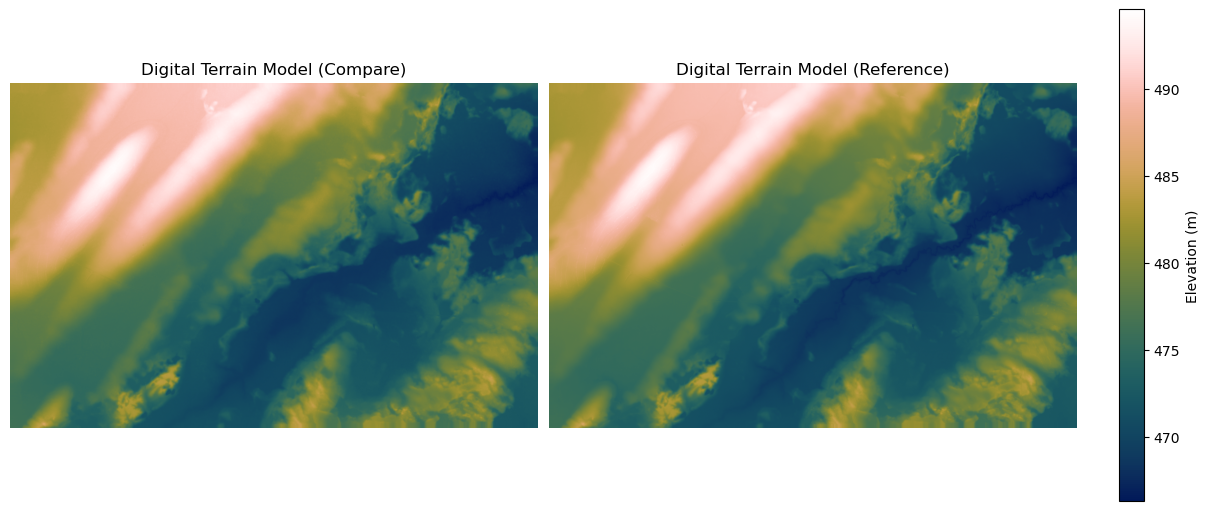

In [16]:
fig = change_dtms.plot_pair(
        overlay = None,
        titles=("Digital Terrain Model (Compare)", "Digital Terrain Model (Reference)"),
        base_cmap=cmaps.batloww,
        legend = "Elevation (m)",
    )

<h3 id="Hillshade">Compute and plot the compare and reference hillshade rasters</h3>

In [ ]:

out_folder_der = "data/derivatives/"
os.mkdir(out_folder_der)

td = TerrainDerivatives(out_folder_der)

compare_hillshade_dtm = Raster(td.hillshade(compare_dtm.path, azimuth=315, altitude=45))
reference_hillshade_dtm = Raster(td.hillshade(reference_dtm.path, azimuth=315, altitude=45))
hillshades_dtm = RasterPair(raster1 = compare_hillshade_dtm, raster2 = reference_hillshade_dtm)

compare_hillshade_dsm = Raster(td.hillshade(compare_dsm.path, azimuth=315, altitude=45))
reference_hillshade_dsm = Raster(td.hillshade(reference_dsm.path, azimuth=315, altitude=45))
hillshades_dsm = RasterPair(raster1 = compare_hillshade_dsm.path, raster2 = reference_hillshade_dsm.path)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions.py:109: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


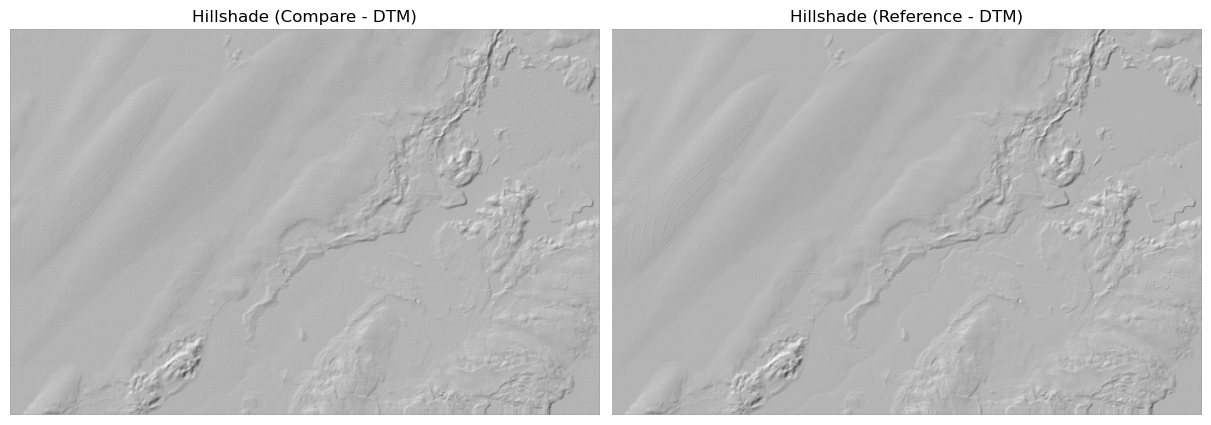

In [18]:
fig = hillshades_dtm.plot_pair(
        overlay = None,
        titles=("Hillshade (Compare - DTM)", "Hillshade (Reference - DTM)"),
        base_cmap=cmaps.gray,
    )

<h3 id="Slope">Compute and plot the compare and reference slope rasters</h3>

In [19]:
compare_slope_dtm = Raster(td.slope(compare_dtm.path))
reference_slope_dtm = Raster(td.slope(reference_dtm.path))
slope_dtm = RasterPair(raster1 = compare_slope_dtm, raster2 = reference_slope_dtm)


compare_slope_dsm = Raster(td.slope(compare_dsm.path))
reference_slope_dsm = Raster(td.slope(reference_dsm.path))
slope_dsm = RasterPair(raster1 = compare_slope_dsm, raster2 = reference_slope_dsm)

In [20]:
fig = slope_dtm.plot_pair(
        overlay = compare_hillshade_dtm,
        overlay_alpha = 0.5,
        titles=("Slope (Compare - DTM)", "Slope (Reference - DTM)"),
        base_cmap=cmaps.sepia_r,
        legend = "Slope (degrees)",
        overlay_cmap=cmaps.neutral,
          
    )

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions.py:109: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


<h3 id="Aspect">Compute and plot the compare and reference aspect rasters</h3>

In [21]:
compare_aspect_dtm = Raster(td.aspect(compare_dtm.path))
reference_aspect_dtm = Raster(td.aspect(reference_dtm.path))
aspect_dtm = RasterPair(raster1 = compare_aspect_dtm, raster2 = reference_aspect_dtm)


compare_aspect_dsm = Raster(td.aspect(compare_dsm.path))
reference_aspect_dsm = Raster(td.aspect(reference_dsm.path))
aspect_dsm = RasterPair(raster1 = compare_aspect_dsm, raster2 = reference_aspect_dsm)


In [22]:
fig = aspect_dtm.plot_pair(
        overlay = None,
        titles=("Aspect (Compare - DTM)", "Aspect (Reference - DTM)"),
        base_cmap=cmaps.romao,
        legend = "Aspect (degrees)",
    )

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions.py:109: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


<h3 id="Roughness">Compute and plot the compare and reference roughness rasters</h3>

In [23]:
compare_roughness_dtm = Raster(td.roughness(compare_dtm.path))
reference_roughness_dtm = Raster(td.roughness(reference_dtm.path))
roughness_dtm = RasterPair(raster1 = compare_roughness_dtm, raster2 = reference_roughness_dtm)


compare_roughness_dsm = Raster(td.roughness(compare_dsm.path))
reference_roughness_dsm = Raster(td.roughness(reference_dsm.path))
roughness_dsm = RasterPair(raster1 = compare_roughness_dsm, raster2 = reference_roughness_dsm)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions.py:109: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


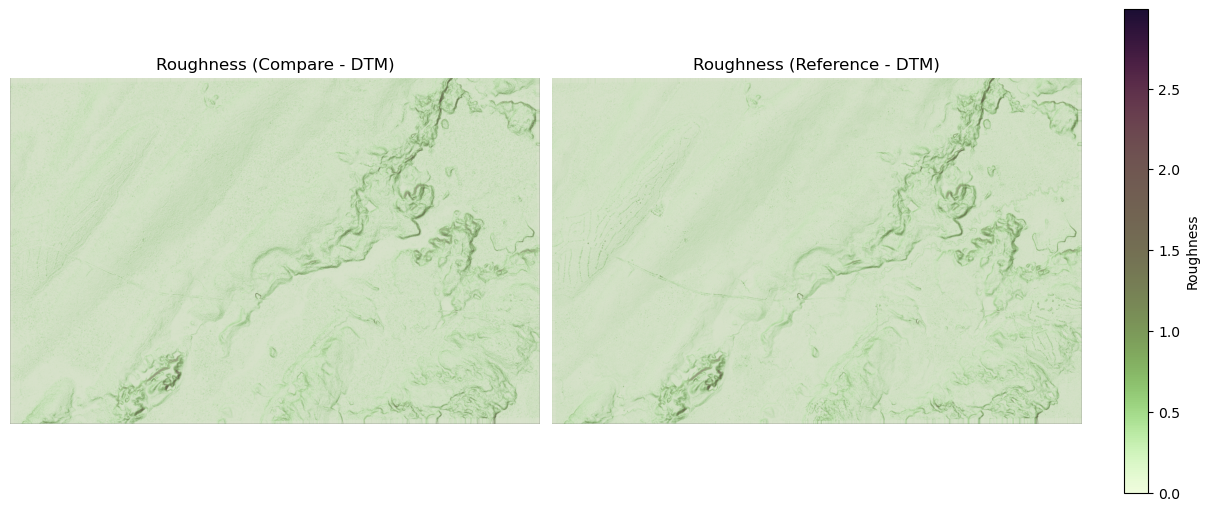

In [24]:
fig = roughness_dtm.plot_pair(
        overlay = compare_hillshade_dtm,
        overlay_alpha = 0.3,
        titles=("Roughness (Compare - DTM)", "Roughness (Reference - DTM)"),
        base_cmap=cmaps.tokyo_r,
        legend = "Roughness",
        overlay_cmap=cmaps.neutral,
    )

<h2 id="Differencing">4. Differencing</h2>

In [ ]:

out_folder_diff = "data/differencing/"
os.mkdir(out_folder_diff)
topodiff = TopoDifferencer(out_folder_diff)

In [27]:
dtm_diff = topodiff.save_difference_raster(change_dtms, 'dtm_diff')

In [30]:
fig = topodiff.plot_difference(
        diff_path = dtm_diff.path,
        overlay = compare_hillshade_dtm,
        cmap="RdBu",
        vmin = -1,
        vmax = 1,
        center_zero = True,
        overlay_alpha = 0.4,
        title = "Topographic difference (DTMs)",
)

<h2 id="Error Analysis">5. Error Analysis</h2>

<h3 id="Define stable areas">Define stable areas</h3>


In [ ]:
out_folder_poly = "data/polygons/"
os.mkdir(out_folder_poly)

interactor = TopoMapInteractor(
    topo_diff_path=dtm_diff.path,
    hillshade_path=compare_hillshade_dtm.path,
    output_dir=out_folder_poly
)

interactor.map

Map(center=[47.21117294175492, -92.0537437788897], controls=(ZoomControl(options=['position', 'zoom_in_text', …

ControlException: control already on map: DrawControl(options=['position'], polygon={'shapeOptions': {'weight': 2, 'fillOpacity': 0.3}})

In [31]:
interactor.stable_geoms

[<POLYGON ((-92.06 47.221, -92.06 47.213, -92.046 47.213, -92.044 47.215, -92...>,
 <POLYGON ((-92.075 47.211, -92.078 47.208, -92.071 47.205, -92.069 47.202, -...>,
 <POLYGON ((-92.046 47.208, -92.052 47.204, -92.05 47.202, -92.048 47.201, -9...>]

<h3 id="Descriptive Statistics">Descriptive Statistics</h3>

In [32]:
stable_polys, unstable_polys = interactor.get_geodataframes()

# one combined mask
rasterizer_stable = StableAreaRasterizer(interactor.topo_diff.path, stable_polys, nodata=-9999)
analyzer_stable = StableAreaAnalyzer(rasterizer_stable)

# Combined-area stats
df_all_stable_polys = analyzer_stable.stats_all('data/polygons/combined_stable.tif')

# Per-area stats
df_each_stable_poly = analyzer_stable.stats_each('data/polygons/each_stable/')


In [33]:
df_all_stable_polys

mean    median      mode       std  variance       min  \
all_areas -0.116893 -0.111511 -0.112701  0.119454  0.014269 -1.374756   

                max  skewness  kurtosis  0.5_percentile  99.5_percentile  
all_areas  1.618683 -0.139842  2.205188       -0.473358         0.212372

In [34]:
df_each_stable_poly

mean    median      mode       std  variance       min       max  \
area_id                                                                         
0       -0.148877 -0.145447 -0.112701  0.123430  0.015235 -1.374756  1.377930   
1       -0.094430 -0.093231 -0.076385  0.091608  0.008392 -0.870361  1.166534   
2       -0.069264 -0.064270 -0.052307  0.113799  0.012950 -1.358490  1.618683   

         skewness  kurtosis  0.5_percentile  99.5_percentile  
area_id                                                       
0       -0.063242  2.127793       -0.509128         0.196716  
1        0.046246  2.445400       -0.361732         0.162109  
2       -0.024405  2.955095       -0.402557         0.253906

<h3 id="Estimate systematic error">Estimate systematic error</h3>

In [35]:
vert_diff_path_dtm = 'data/polygons/combined_stable.tif'
output_path = 'data/polygons/combined_stable_bias_removed.tif'

unit = "m"
dem_resolution = 1.0

In [36]:
#Load raster data
raster_data_handler_dtm=RasterDataHandler(vert_diff_path_dtm, unit, dem_resolution)
raster_data_handler_dtm.load_raster()

vert_diff_array_dtm = raster_data_handler_dtm.data_array

#With the assumption that the distribution of vertical differences should be centered on zero given a large enough area, let's take the median as the measure of vertical bias.
vertical_bias = np.median(vert_diff_array_dtm)

#Get a measure of the uncertainty in the median value by bootstrap resampling (10% of the total observations, 1000x)
stats_dtm = StatisticalAnalysis(raster_data_handler_dtm)
median_uncertainty = stats_dtm.bootstrap_uncertainty_subsample()

#Subtract the vertical bias from the original raster and save as a file
raster_data_handler_dtm.subtract_value_from_raster(output_path, vertical_bias)

#Create new raster handling instance for modified raster, load raster and create data array
raster2_data_handler=RasterDataHandler(output_path, unit, dem_resolution)
raster2_data_handler.load_raster()


In [37]:
vertical_bias

np.float32(-0.11151123)

In [38]:
fig = stats_dtm.plot_data_stats()

<h3 id="Estimate correlated error">Estimate correlated error</h3>

In [45]:
#Create variogram analysis instance based on modified raster
V = VariogramAnalysis(raster2_data_handler)

#Calculate a mean variogram with 75 bins from variograms made over 10 runs
V.calculate_mean_variogram_numba(area_side = 250, samples_per_area = 400, max_samples = 1000000000, bin_width = 30, max_n_bins = 3000, n_runs = 30, max_lag_multiplier = 0.6)

In [46]:
V.fit_best_spherical_model()

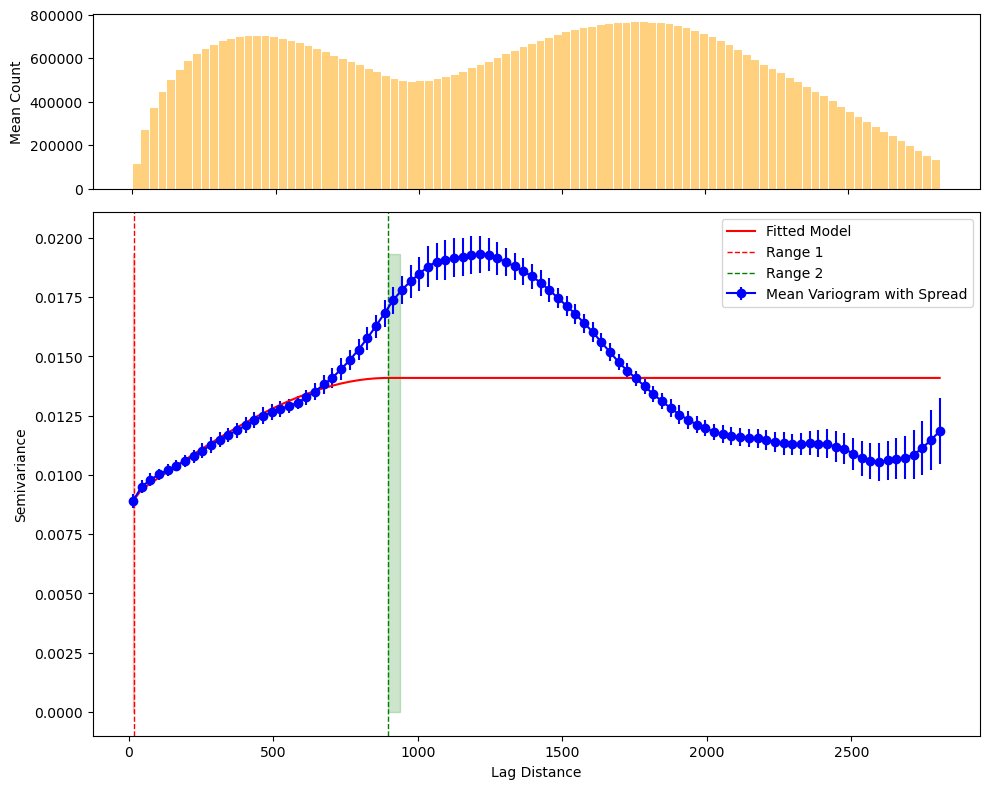

In [47]:
fig = V.plot_best_spherical_model()

<h3 id="Total mean error">Total mean error</h3>

In [48]:
uncertainty = UncertaintyCalculation(V)

#Calculate mean, random, uncorrelated uncertainty
uncertainty.calc_mean_random_uncorrelated()

#Calculate mean, random, correlated uncertainty, for optimal, minimum and maximum ranges and sills 
uncertainty.calc_mean_random_correlated()
uncertainty.calc_mean_random_correlated_min()
uncertainty.calc_mean_random_correlated_max()

#Calculate total mean uncertainty
uncertainty.calc_total_mean_uncertainty()
uncertainty.calc_total_mean_uncertainty_min()
uncertainty.calc_total_mean_uncertainty_max()

In [49]:
print(f'vertical bias: {vertical_bias}')
print('')
print(f'component uncertainties: {uncertainty.mean_random_correlated_1,uncertainty.mean_random_correlated_2,uncertainty.mean_random_correlated_3}')
print(f'max component uncertainties : {uncertainty.mean_random_correlated_1_max,uncertainty.mean_random_correlated_2_max,uncertainty.mean_random_correlated_3_max}')
print(f'min component uncertainties : {uncertainty.mean_random_correlated_1_min,uncertainty.mean_random_correlated_2_min,uncertainty.mean_random_correlated_3_min}')
print('')
print(f'mean random uncorrelated uncertainty : {uncertainty.mean_random_uncorrelated}')
print('')
print(f'total mean uncertainty : {uncertainty.total_mean_uncertainty}')
print(f'max total mean uncertainty : {uncertainty.total_mean_uncertainty_max}')
print(f'min total mean uncertainty : {uncertainty.total_mean_uncertainty_min}')
print('')
print(f'area (m^2): {len(raster2_data_handler.data_array)}')

vertical bias: -0.11151123046875

component uncertainties: (np.float64(0.0011863746510085017), np.float64(0.04625704150552708), None)
max component uncertainties : (np.float64(0.0011797284198075406), np.float64(0.05150786183933508), None)
min component uncertainties : (np.float64(0.000983409947722846), np.float64(0.04750190650468107), None)

mean random uncorrelated uncertainty : 7.702086145216911e-05

total mean uncertainty : 0.04627231684138702
max total mean uncertainty : 0.051521427800650395
min total mean uncertainty : 0.04751214738272562

area (m^2): 2405741


In [50]:
interactor.map

Map(bottom=2943664.0, center=[47.21117294175492, -92.0537437788897], controls=(ZoomControl(options=['position'…

In [51]:
interactor.unstable_geoms

[<POLYGON ((-92.05 47.21, -92.051 47.209, -92.052 47.208, -92.052 47.208, -92...>]

In [52]:
# compute RMS:
rms = ApplyUncertainty.compute_rms_from_tif('data/polygons/combined_stable_bias_removed.tif')

# get latest version of the unstable polygons
_, unstable_polys = interactor.get_geodataframes()
unstable_area_m2 = unstable_polys.area.sum()

# compute uncertainties:
unc = ApplyUncertainty.compute_spatial_uncertainties(
    V.ranges, V.sills,
    area=unstable_area_m2,
    resolution=dem_resolution,
    rms=rms,
    sills_min=V.sills_min,
    ranges_min=V.ranges_min,
    sills_max=V.sills_max,
    ranges_max=V.ranges_max,
)
print(unc)

{'uncorrelated': 0.00028956886337226694, 'correlated': [0.004456124581084662, 0.17374540118992776], 'total': 0.17380277710973935, 'total_min': 0.17845968657162206, 'total_max': 0.19351888643472892}
